# LSTM Model + Pfizer 

## Load Pacakage

In [1]:
from pandas import read_csv
import numpy as np
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## Load Data

Reading data and splitting into train and test by extract 20% of data into test data.

In [2]:
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
sunspots_url = 'data/LSTM_Pfizer.csv'
train_data, test_data, data = get_train_test(sunspots_url)

Reshaping data for keras by diving the x(independent variables) and y(dependent variables).

In [3]:
def get_XY(dat, time_steps, delay = 0):
    Y_ind = np.arange(time_steps + delay, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = []
    for i in range(rows_x):
        X_ind = np.arange(i, i + time_steps, 1)
        temp = dat[X_ind]
        X.append(temp)
    X=np.array(X)
    # X = np.resize(X, (rows_x, time_steps, 1))
    # X = X.reshape(-1,1).reshape(rows_x, time_steps, 1)
    X= np.reshape(X, (X.shape[0], X.shape[1], 1))
    Y=np.reshape(Y, (Y.shape[0], 1))
    return X, Y
 
time_steps = 30
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)


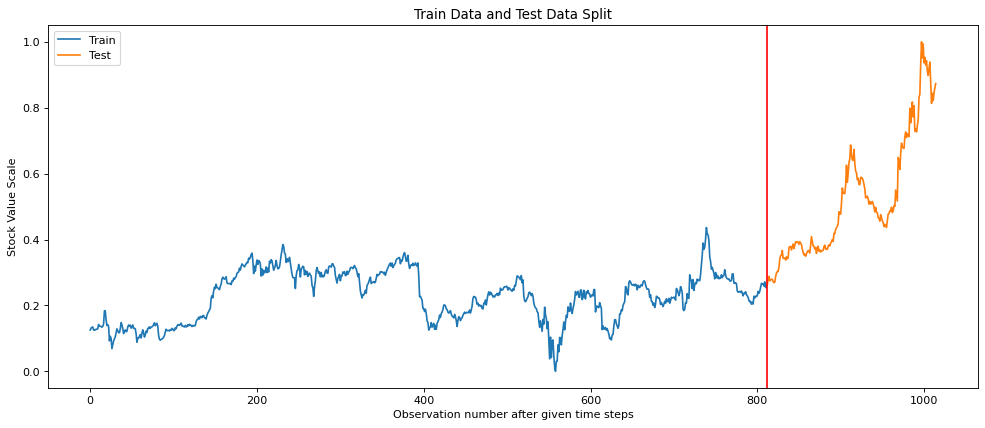

In [4]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(range(len(train_data)), train_data)
plt.plot(range(len(train_data),len(train_data)+len(test_data)), test_data)
plt.axvline(x=len(train_data), color='r')
plt.legend(['Train', 'Test'])
plt.xlabel('Observation number after given time steps')
plt.ylabel('Stock Value Scale')
plt.title('Train Data and Test Data Split')
plt.show()

Create LSTM fodel and fit the train model

In [5]:
np.random.seed(9527)
tensorflow.random.set_seed(9527)
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
#LSTM=testmodel.fit(trainX[:trainX.shape[0]-10,:,:], trainY[:trainX.shape[0]-10,:], epochs=20, batch_size=1, verbose=2,
              #validation_data=(trainX[trainX.shape[0]-10:,:,:],trainY[trainX.shape[0]-10:,:]))

LSTM=model.fit(trainX[:trainX.shape[0]-10,:,:], trainY[:trainX.shape[0]-10,:], epochs=20, batch_size=1, verbose=2,
              validation_data=(trainX[trainX.shape[0]-10:,:,:],trainY[trainX.shape[0]-10:,:]),
              callbacks=[callback])


Epoch 1/20
772/772 - 7s - loss: 0.0394 - val_loss: 0.0013 - 7s/epoch - 9ms/step
Epoch 2/20
772/772 - 5s - loss: 0.0042 - val_loss: 0.0010 - 5s/epoch - 7ms/step
Epoch 3/20
772/772 - 5s - loss: 0.0017 - val_loss: 0.0015 - 5s/epoch - 7ms/step
Epoch 4/20
772/772 - 5s - loss: 0.0013 - val_loss: 9.4243e-04 - 5s/epoch - 6ms/step
Epoch 5/20
772/772 - 6s - loss: 0.0011 - val_loss: 0.0013 - 6s/epoch - 7ms/step
Epoch 6/20
772/772 - 6s - loss: 8.8830e-04 - val_loss: 2.4681e-04 - 6s/epoch - 8ms/step
Epoch 7/20
772/772 - 6s - loss: 7.5930e-04 - val_loss: 2.9359e-04 - 6s/epoch - 8ms/step
Epoch 8/20
772/772 - 5s - loss: 6.2593e-04 - val_loss: 4.4078e-04 - 5s/epoch - 6ms/step


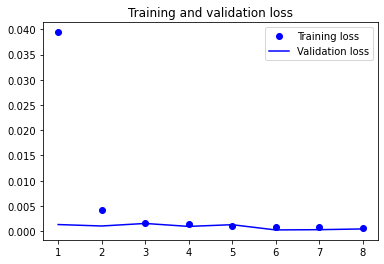

In [6]:
loss = LSTM.history['loss']
val_loss = LSTM.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Compute and print the root mean square error. From the result, it show both train RMSE and test RMSE are small which means this model offer a good prediction.

In [7]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.024 RMSE
Test RMSE: 0.127 RMSE


Comparing predictions and actual value in plot. From the line plot, it shows the predicted values are really close to actual value.

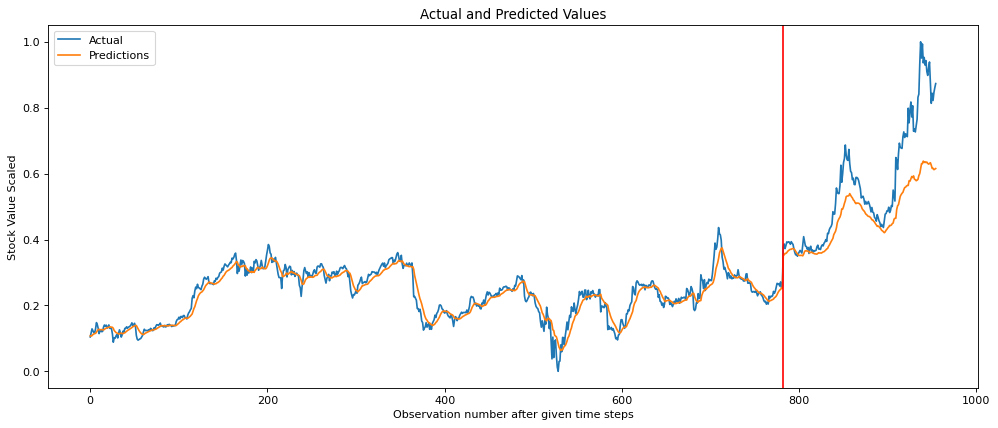

In [8]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    #rows = len(predictions)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(len(actual)), actual)
    plt.plot(range(len(predictions)), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Stock Value Scaled')
    plt.title('Actual and Predicted Values')
plot_result(trainY, testY, train_predict, test_predict)

Base on the prediction data and forest 50 days. 

In [9]:

newX, newY = get_XY(test_predict, time_steps)
new_predict = np.append(test_predict,model.predict(np.array([newX[-1]])))
for i in range(29):
    newX, newY = get_XY(new_predict, time_steps)
    new_predict = np.append(new_predict,model.predict(np.array([newX[-1]])))

In [10]:
def plot_forecaset(trainY, testY, train_predict, test_predict,new_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    forecast = new_predict[len(test_predict)-1:]
    #rows = len(predictions)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(len(actual)), actual)
    plt.plot(range(len(predictions)), predictions)
    plt.plot(range(len(predictions),len(predictions)+len(forecast)), forecast)
    plt.axvline(x=len(trainY), color='r')
    plt.axvline(x=len(predictions), color='brown')
    plt.legend(['Actual', 'Predictions','Forecast'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Stock Value Scaled')
    plt.title('Actual,Predicted and Forecast Values')

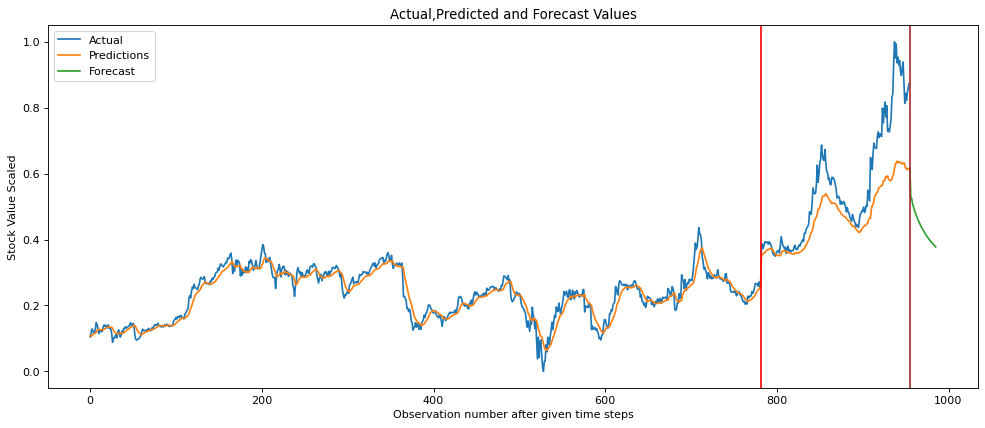

In [11]:
plot_forecaset(trainY, testY, train_predict, test_predict,new_predict)